# 足部测量系统 - 基于A4纸参考
# # 足部测量系统

本项目实现基于A4纸参考的足部测量系统，包含以下功能：
- A4纸检测和透视校正
- 足部区域分割
- 轮廓提取和测量计算
- 结果可视化和数据导出
<!-- 注，使用干净白纸，图片中心是脚，闪光灯拍照效果会更好 -->
# 使用方法
1. 将脚后跟紧贴A4纸边缘
2. 俯视拍照，确保A4纸完整入镜
3. 运行代码进行自动处理

In [1]:
# 足部测量系统 - 边缘检测方法
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from foot_report import run_shoe_recommendation
from process_foot import process_foot_measurement

# 加载模型
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

图像尺寸: (4096, 3072, 3)


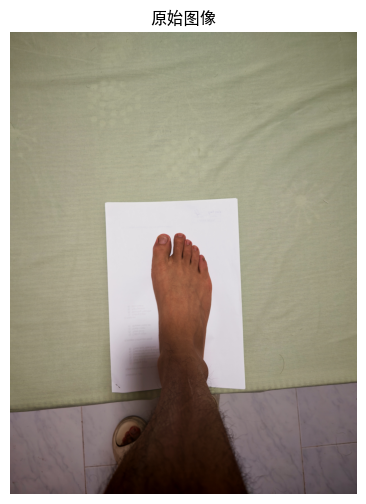

In [2]:
# 读取图像
TEST_IMAGE_PATH = "foot_with_a4_real.jpg"  # 修改为你的图像路径
image = cv2.imread(TEST_IMAGE_PATH)
print(f"图像尺寸: {image.shape}")

# 显示原始图像
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("原始图像")
plt.axis('off')
plt.show()

In [3]:
# 读取图像
image = cv2.imread(TEST_IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

# 获取图像尺寸并计算中心点
height, width = image.shape[:2]
center_x = width // 2
center_y = height // 2

# 点击图像中心
input_point = np.array([[center_x, center_y]])  # [x, y] 坐标
input_label = np.array([1])  # 1表示前景点

# 生成mask
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

# 保存mask
center_mask = masks[0].astype(np.uint8) * 255
cv2.imwrite("result\center_mask.png", center_mask)
print("中心点mask已保存到 center_mask.png")


中心点mask已保存到 center_mask.png


分割区域面积: 1372638 像素
置信度分数: 0.961


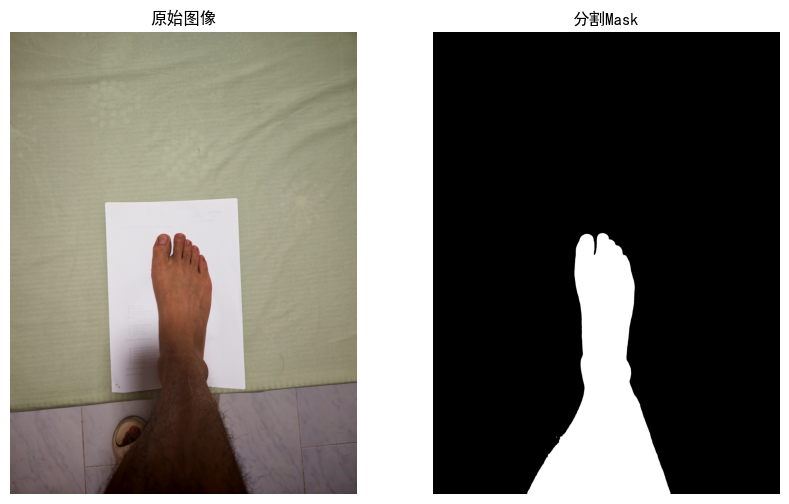

In [4]:
# 显示结果信息
mask_area = np.sum(masks[0])
print(f"分割区域面积: {mask_area} 像素")
print(f"置信度分数: {scores[0]:.3f}")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("原始图像")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(masks[0], cmap='gray')
plt.title("分割Mask")
plt.axis('off')
plt.show()

In [5]:

predictor.set_image(image)

# 使用已存在的足部mask变量 center_mask
foot_mask = center_mask

# 找到足部的最顶端位置
foot_pixels = np.where(foot_mask > 0)  # 找到所有白色像素
top_y = np.min(foot_pixels[0])  # 最小的y坐标就是顶部

# 在顶部找到中心的x坐标
top_row_pixels = np.where(foot_mask[top_y, :] > 0)[0]  # 顶部行的所有x坐标
center_x = int(np.mean(top_row_pixels))  # 顶部的中心x坐标

# 在足部顶部往上2个像素的位置点击
paper_y = max(0, top_y - 20)  # 往上20像素点，但不能超出图像边界
paper_point = np.array([[center_x, paper_y]])

print(f"足部顶部位置: ({center_x}, {top_y})")
print(f"A4纸点击位置: ({center_x}, {paper_y})")

# 点击A4纸位置
input_point = paper_point
input_label = np.array([1])  # 1表示前景点

# 生成A4纸mask
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

# 保存A4纸mask
a4_mask = masks[0].astype(np.uint8) * 255
cv2.imwrite("result\\a4_mask.png", a4_mask)

print("A4纸mask已保存到 a4_mask.png")
print(f"A4纸区域面积: {np.sum(masks[0])} 像素")
print(f"置信度分数: {scores[0]:.3f}")



足部顶部位置: (1498, 1782)
A4纸点击位置: (1498, 1762)
A4纸mask已保存到 a4_mask.png
A4纸区域面积: 1344662 像素
置信度分数: 1.001


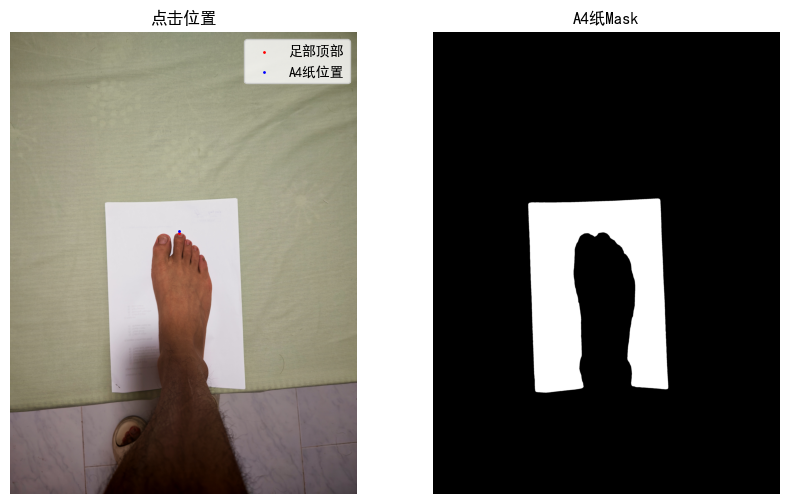

In [6]:
# 可选：可视化点击位置
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.scatter([center_x], [top_y], c='red', s=1, label='足部顶部')
plt.scatter([center_x], [paper_y], c='blue', s=1, label='A4纸位置')
plt.title("点击位置")
plt.axis('off')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(masks[0], cmap='gray')
plt.title("A4纸Mask")
plt.axis('off')
plt.show()

A4纸4个角点:
  左上: (851.0, 1515.0)
  右上: (2007.0, 1481.0)
  右下: (2080.0, 3160.0)
  左下: (907.0, 3185.0)
完成！保存到 warped_a4.png


C:\Users\21202\AppData\Local\Temp\ipykernel_35884\2424128049.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


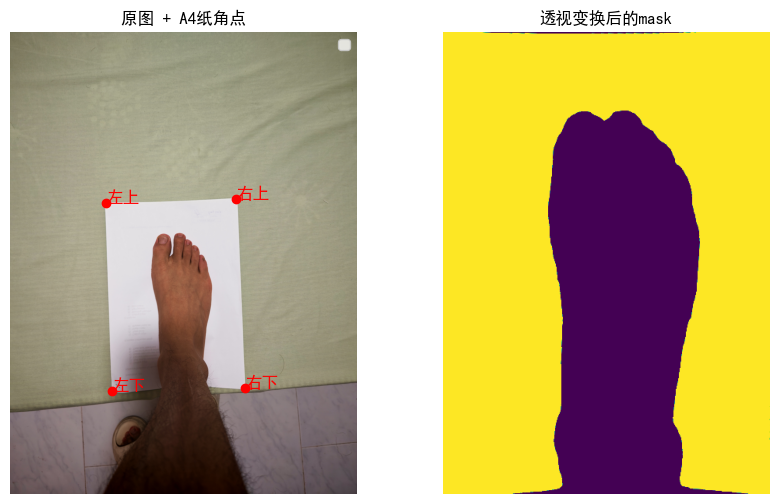

In [7]:

# 找到A4纸mask中所有白色像素的坐标
y_coords, x_coords = np.where(a4_mask > 0)

# 直接计算4个角点
top_left = [x_coords[np.argmin(x_coords + y_coords)], y_coords[np.argmin(x_coords + y_coords)]]  # x+y最小
top_right = [x_coords[np.argmax(x_coords - y_coords)], y_coords[np.argmax(x_coords - y_coords)]]  # x-y最大
bottom_left = [x_coords[np.argmin(x_coords - y_coords)], y_coords[np.argmin(x_coords - y_coords)]]  # x-y最小
bottom_right = [x_coords[np.argmax(x_coords + y_coords)], y_coords[np.argmax(x_coords + y_coords)]]  # x+y最大

# 按顺序排列：左上、右上、右下、左下
corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)

print("A4纸4个角点:")
corner_names = ['左上', '右上', '右下', '左下']
for corner, name in zip(corners, corner_names):
    print(f"  {name}: ({corner[0]:.1f}, {corner[1]:.1f})")

# 定义新图像尺寸
new_width = 420
new_height = int(new_width * 29.7 / 21)  # A4比例

# 目标角点
dst_corners = np.array([
    [0, 0],
    [new_width - 1, 0],
    [new_width - 1, new_height - 1],
    [0, new_height - 1]
], dtype=np.float32)

# 透视变换
transform_matrix = cv2.getPerspectiveTransform(corners, dst_corners)
warped_image = cv2.warpPerspective(a4_mask, transform_matrix, (new_width, new_height))

# 保存
warped_image_bgr = cv2.cvtColor(warped_image, cv2.COLOR_GRAY2BGR)
warped_a4_path="result\warped_a4.png"  # 修改为你想保存的路径
cv2.imwrite(warped_a4_path, warped_image_bgr)
print("完成！保存到 warped_a4.png")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("原图 + A4纸角点")
plt.imshow(image)
for corner, name in zip(corners, corner_names):
    plt.plot(corner[0], corner[1], 'ro')
    plt.text(corner[0] + 5, corner[1] - 5, name, color='red', fontsize=12)  
plt.axis('off')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(warped_image)
plt.title("透视变换后的mask")
plt.axis('off')
plt.show()

🔍 步骤1: 检测足部...
✅ 检测到足部，足长: 246.0 mm
🔧 步骤2: 椭圆修正足后跟区域...
✅ 椭圆修正完成（足后跟起始位置: 504px）

📏 步骤3: 每5mm测量足宽...

距脚尖距离(mm) | 足宽(mm) | 足宽(cm)
----------------------------------------
     0.0      |     5.5 |   0.55
     5.0      |    46.0 |   4.60
    10.0      |    52.0 |   5.20
    15.0      |    60.5 |   6.05
    20.0      |    68.0 |   6.80
    25.0      |    75.0 |   7.50
    30.0      |    77.5 |   7.75
    35.0      |    80.5 |   8.05
    40.0      |    84.5 |   8.45
    45.0      |    87.5 |   8.75
    50.0      |    90.0 |   9.00
    55.0      |    91.0 |   9.10
    60.0      |    92.0 |   9.20
    65.0      |    93.0 |   9.30
    70.0      |    94.0 |   9.40
    75.0      |    95.0 |   9.50
    80.0      |    95.5 |   9.55
    85.0      |    95.5 |   9.55
    90.0      |    93.5 |   9.35
    95.0      |    92.0 |   9.20
   100.0      |    91.0 |   9.10
   105.0      |    90.0 |   9.00
   110.0      |    88.5 |   8.85
   115.0      |    87.5 |   8.75
   120.0      |    86.0 |   8.60
   1

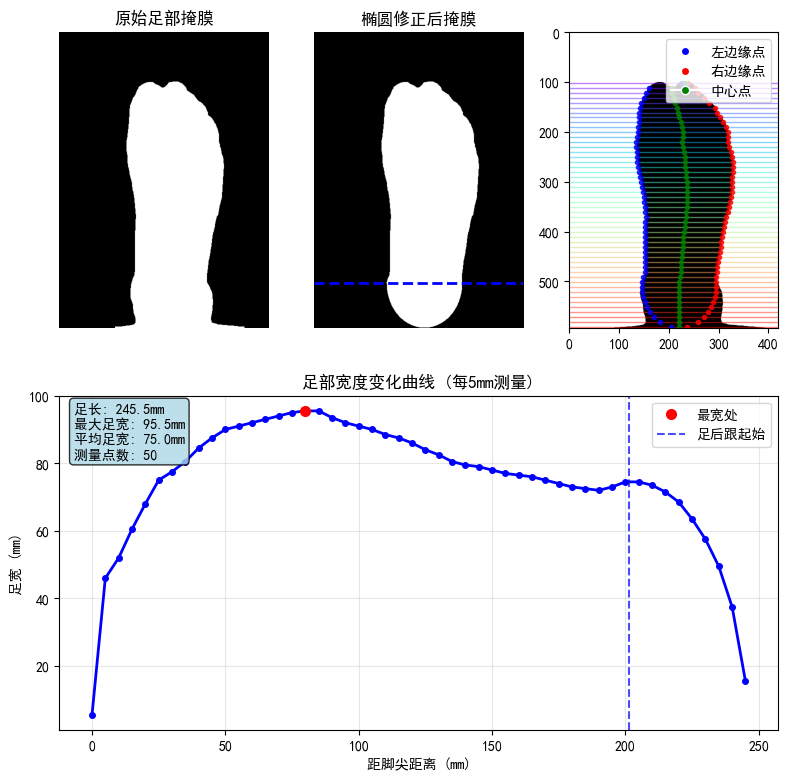

In [8]:
# 运行测量和报告生成
results,process_foot_measurement_path = process_foot_measurement(image_path=warped_a4_path, save_results=True)
foot_length_mm = results['foot_length_mm']
foot_width_mm = results['max_width_mm']
print(f"测量结果 - 脚长: {foot_length_mm:.1f} mm, 脚宽: {foot_width_mm:.1f} mm")



智能鞋码推荐报告



📏 测量数据:
脚长: 245.5 mm (24.6 cm)
   脚宽: 95.5 mm (9.6 cm)

宽长比: 0.389

--------------------------------------------------------------------------------

国际尺码推荐表:


+------------+------------+-----------------+------------+----------------------+
|    类别    |    国家    |    推荐尺码     |  宽度类型  |       特别建议       |
+------------+------------+-----------------+------------+----------------------+
|    男鞋    |    中国    |      40.0       |     D      |    建议考虑大半码    |
|            |    欧洲    |      40.0       |            |                      |
|            |    美国    |       7.0       |            |                      |
|            |    英国    |       6.5       |            |                      |
|            |    日本    |     25.0cm      |            |                      |
| ---------- | ---------- | --------------- | ---------- | -------------------- |
|    女鞋    |    中国    |      39.5       |     EE     |    建议考虑大半码    |
|            |    欧洲    |      39.5       |         

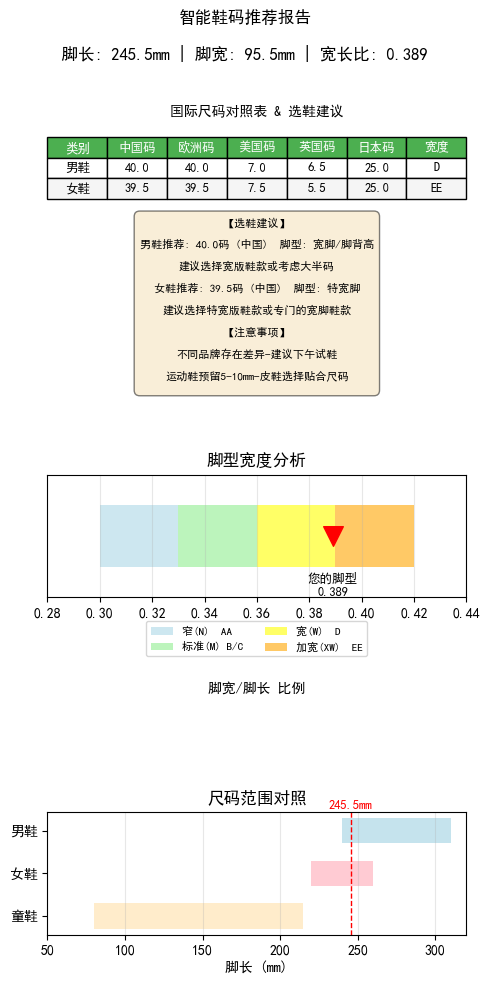

In [9]:
report=run_shoe_recommendation(foot_length_mm, foot_width_mm)

In [10]:
from openai import OpenAI
import json

client = OpenAI(api_key="sk-198343e3213d42e8bc17c259a4398c56", base_url="https://api.deepseek.com")

# 构建结构化的数据
foot_data = {
    "measurement_results": results,
    "analysis_report": report,
    "processing_path": process_foot_measurement_path
}

user_content = f"""
基于以下足部测试数据，请提供专业的：
1. 3D打印鞋晶格设计建议（包括材料、密度分布、结构类型）
2. 个性化的运动健康建议
3. 鞋具选择指导

数据详情：
{json.dumps(foot_data, indent=2, ensure_ascii=False)}
"""

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "你是一名足部矫形师和运动康复专家，擅长3D打印鞋具设计"},
        {"role": "user", "content": user_content},
    ],
    stream=False,
    temperature=0.7  # 控制创造性，较低值更事实性
)

print("=" * 50)
print("专业建议：")
print("=" * 50)
print(response.choices[0].message.content)

专业建议：
根据您提供的详细足部测量数据，我将为您提供专业的3D打印鞋具设计建议、运动健康指导和鞋具选择建议。

## 1. 3D打印鞋晶格设计建议

**材料选择：**
- 主要材料：TPU（热塑性聚氨酯），硬度建议在85A-95A之间
- 支撑区域：选择性使用尼龙PA12增强关键支撑部位

**晶格密度分布策略：**
- **后跟区域**（0-60mm）：高密度晶格（75-85%填充率），提供稳定支撑
- **足弓区域**（60-150mm）：中等密度渐变（50-70%），内侧密度略高于外侧
- **前掌区域**（150-245mm）：前部中等密度（60%），趾骨区域降低密度（40%）以提供灵活性
- **边缘区域**：周边密度增加5-10%以提供侧向支撑

**结构类型建议：**
- 使用**渐变式六边形晶格结构**，在高压区域采用更小的晶格单元
- 足弓内侧采用**加强筋结构**提供额外支撑
- 前掌区域采用**各向异性晶格**，确保前后弯曲灵活而侧向稳定

## 2. 个性化运动健康建议

基于您的宽脚型特征（宽度比例0.389）：

**日常训练建议：**
1. **足部强化训练**：
   - 毛巾抓取练习：每天3组，每组15次
   - 足弓提升训练：坐姿时内收足弓，保持5秒，重复20次
   - 小腿拉伸：每天进行跟腱和小腿肌群拉伸

2. **运动选择**：
   - 推荐：游泳、 cycling、椭圆机训练
   - 谨慎选择：高冲击运动如篮球、跑步（需配合专业鞋具）

3. **恢复护理**：
   - 每日足部滚轮按摩5-10分钟
   - 晚间进行冷水足浴（如感觉不适）
   - 定期进行足底筋膜放松

## 3. 鞋具选择指导

**购买建议：**
- **鞋码选择**：建议选择比标准码大半码（如男款US 7.5）
- **宽度要求**：必须选择宽版（W/2E）或特宽版（XW/4E）鞋型
- **关键特征**：
  - 宽楦头设计，确保前掌有足够空间
  - 可调节的鞋带系统
  - 良好的足弓支撑
  - 透气性佳的鞋面材料

**推荐品牌系列：**
- New Balance：Fresh Foam系列，宽度选项齐全
- ASICS：GEL-Kayano系列宽版
- Brooks：Adrenaline GTS系列宽版
- HOKA：B